# 성능개선 기법 실습

# 모듈 정의

## train.py
- 모델 학습과 검증 함수 정의

In [1]:
import os
os.makedirs('module', exist_ok=True)

In [1]:
%%writefile module/train.py

import torch
import time

def test_multi_classification(dataloader, model, loss_fn, device="cpu") -> tuple:
    """
    다중 분류 검증/평가 함수
    
    [parameter]
        dataloader: DataLoader - 검증할 대상 데이터로더
        model: 검증할 모델
        loss_fn: 모델 추정값과 정답의 차이를 계산할 loss 함수.
        device: str - 연산을 처리할 장치. default-"cpu", gpu-"cuda"
    [return]
        tuple: (loss, accuracy)
    """
    model = model.to(device)
    model.eval() 
    size = len(dataloader.dataset)
    num_steps = len(dataloader)
    
    test_loss, test_accuracy = 0., 0.
    
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            # 정확도 계산
            pred_label = torch.argmax(pred, axis=-1)
            test_accuracy += torch.sum(pred_label == y).item()
            
        test_loss /= num_steps
        test_accuracy /= size
    return test_loss, test_accuracy

def test_binary_classification(dataloader, model, loss_fn, device="cpu") -> tuple:
    """
    이진 분류 검증/평가 함수
    
    [parameter]
        dataloader: DataLoader - 검증할 대상 데이터로더
        model: 검증할 모델
        loss_fn: 모델 추정값과 정답의 차이를 계산할 loss 함수.
        device: str - 연산을 처리할 장치. default-"cpu", gpu-"cuda"
    [return]
        tuple: (loss, accuracy)
    """
    model = model.to(device)
    model.eval() # 모델을 평가모드로 변환
    size = len(dataloader.dataset)
    num_steps = len(dataloader)
    
    test_loss, test_accuracy = 0., 0.
    
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            ## 정확도 계산
            pred_label = (pred >= 0.5).type(torch.int32)
            test_accuracy += (pred_label == y).sum().item() 
            
        test_loss /= num_steps
        test_accuracy /= size   #전체 개수로 나눈다.
    return test_loss, test_accuracy    

def train(dataloader, model, loss_fn, optimizer, device="cpu", mode:"binary or multi"='binary'):
    """
    모델을 1 epoch 학습시키는 함수

    [parameter]
        dataloader: DataLoader - 학습데이터셋을 제공하는 DataLoader
        model - 학습대상 모델
        loss_fn: 모델 추정값과 정답의 차이를 계산할 loss 함수.
        optimizer - 최적화 함수
        device: str - 연산을 처리할 장치. default-"cpu", gpu-"cuda"
        mode: str - 분류 종류. binary 또는 multi
    [return]
        tuple: 학습후 계산한 Train set에 대한  train_loss, train_accuracy
    """
    model.train()
    size = len(dataloader.dataset) 

    for X, y in dataloader:
        X, y = X.to(device), y.to(device)
        pred = model(X)

        loss = loss_fn(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    if mode == 'binary':
        train_loss, train_accuracy = test_binary_classification(dataloader, model, loss_fn, device)
    else:
        train_loss, train_accuracy = test_multi_classification(dataloader, model, loss_fn, device)
    return train_loss, train_accuracy


def fit(train_loader, val_loader, model, loss_fn, optimizer, epochs, save_best_model=True, 
        save_model_path=None, early_stopping=True, patience=10, device='cpu',  
        mode:"binary or multi"='binary',
        lr_scheduler=None):
    """
    모델을 학습시키는 함수

    [parameter]
        train_loader (Dataloader): Train dataloader
        test_loader (Dataloader): validation dataloader
        model (Module): 학습시킬 모델
        loss_fn (Loss): Loss function
        optimizer (Optimizer): Optimizer
        epochs (int): epoch수
        save_best_model (bool, optional): 학습도중 성능개선시 모델 저장 여부. Defaults to True.
        save_model_path (str, optional): save_best_model=True일 때 모델저장할 파일 경로. Defaults to None.
        early_stopping (bool, optional): 조기 종료 여부. Defaults to True.
        patience (int, optional): 조기종료 True일 때 종료전에 성능이 개선될지 몇 epoch까지 기다릴지 epoch수. Defaults to 10.
        device (str, optional): device. Defaults to 'cpu'.
        mode(str, optinal): 분류 종류. "binary(default) or multi
         lr_scheduler: Learning Scheduler객체 default=None      ====> 한 에폭 끝날때 마다 learning rate 변경.
    [return]
        tuple: 에폭 별 성능 리스트. (train_loss_list, train_accuracy_list, validation_loss_list, validataion_accuracy_list)
    """

    train_loss_list = []
    train_accuracy_list = []
    val_loss_list = []
    val_accuracy_list = []
    
        
    if save_best_model:
        best_score_save = torch.inf

    ############################
    # early stopping
    #############################
    if early_stopping:
        trigger_count = 0
        best_score_es = torch.inf
    
    # 모델 device로 옮기기
    model = model.to(device)
    s = time.time()
    for epoch in range(epochs):
        train_loss, train_accuracy = train(train_loader, model, loss_fn, optimizer, device=device, mode=mode)
       
        # 한 epoch 학습 종료 후 LR scheduler를 이용해 LR 변경.
        if lr_scheduler is not None:
            c_lr = lr_scheduler.get_last_lr()[0]  #변경전 learning rate 값
            lr_scheduler.step()  # learning rate update
            n_lr = lr_scheduler.get_last_lr()[0]  # 변경후 lr 값
            if c_lr != n_lr:
                print(f"####### Learning rate 를 {c_lr}에서 {n_lr} 로 변경함.")

        
        if mode == "binary":
            val_loss, val_accuracy = test_binary_classification(val_loader, model, loss_fn, device=device)
        else:
            val_loss, val_accuracy = test_multi_classification(val_loader, model, loss_fn, device=device)

        train_loss_list.append(train_loss)
        train_accuracy_list.append(train_accuracy)
        val_loss_list.append(val_loss)
        val_accuracy_list.append(val_accuracy)
        
        print(f"Epoch[{epoch+1}/{epochs}] - Train loss: {train_loss:.5f} Train Accucracy: {train_accuracy:.5f} || Validation Loss: {val_loss:.5f} Validation Accuracy: {val_accuracy:.5f}")
        print('='*100)
        
        # 모델 저장
        if save_best_model:
            if val_loss < best_score_save:
                torch.save(model, save_model_path)
                print(f"<<<<<<<저장: {epoch+1} - 이전 : {best_score_save}, 현재: {val_loss}")
                best_score_save = val_loss
        
        # early stopping 처리            
        if early_stopping:
            if val_loss < best_score_es:  # 성능 개선 (O)
                best_score_es = val_loss  
                trigger_count = 0
                                
            else: # 성능 개선 (X)
                trigger_count += 1                
                if patience == trigger_count:
                    print(f">>>>>>Early stopping: Epoch - {epoch}")
                    break
            
    e = time.time()
    print(e-s, "초")
    return train_loss_list, train_accuracy_list, val_loss_list, val_accuracy_list

Overwriting module/train.py


## data.py
- dataset 생성 함수 제공 모듈

In [3]:
%%writefile module/data.py
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

def load_mnist_dataset(root_path, batch_size, is_train=True):
    """
    mnist dataset dataloader 제공 함수
    [parameter]
        root_path: str|Path - 데이터파일 저장 디렉토리
        batch_size: int
        is_train: bool = True - True: Train dataset, False - Test dataset
    [return]
        DataLoader 
    """
    transform = transforms.Compose([
        transforms.ToTensor()
    ])
    dataset = datasets.MNIST(root=root_path, train=is_train, download=True, transform=transform)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=is_train)  # shuffle: train이면 True, test면 False 할 것이므로 is_train을 넣음.
    
    return dataloader

def load_fashion_mnist_dataset(root_path, batch_size, is_train=True):
    """
    fashion mnist dataset dataloader 제공 함수
    [parameter]
        root_path: str|Path - 데이터파일 저장 디렉토리
        batch_size: int
        is_train: bool = True - True: Train dataset, False - Test dataset
    [return]
        DataLoader
    """
    transform = transforms.Compose([
        transforms.ToTensor()
    ])
    dataset = datasets.FashionMNIST(root=root_path, train=is_train, download=True, transform=transform)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=is_train)  # shuffle: train이면 True, test면 False 할 것이므로 is_train을 넣음.
    
    return dataloader

Overwriting module/data.py


In [18]:
%%writefile module/utils.py
## 학습 결과를 시각화하는 함수.
import matplotlib.pyplot as plt

def plot_fit_result(train_loss_list, train_accuracy_list, valid_loss_list, valid_accuracy_list):
    epoch = len(train_loss_list)
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(range(epoch), train_loss_list, label="train loss")
    plt.plot(range(epoch), valid_loss_list, label="validation loss")
    plt.title("Loss")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.grid(True, linestyle=':')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(epoch), train_accuracy_list, label="train accuracy")
    plt.plot(range(epoch), valid_accuracy_list, label="validation accuracy")
    plt.title("Accuracy")
    plt.xlabel("epoch")
    plt.ylabel("accuracy")
    plt.grid(True, linestyle=':')
    plt.legend()

    plt.tight_layout()
    plt.show()

Writing module/utils.py


## import

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchinfo import summary

from module.train import fit  # fit 함수 import
from module.data import load_mnist_dataset, load_fashion_mnist_dataset
from module.utils import plot_fit_result
print(torch.__version__)

2.3.0+cpu


## 하이퍼파라미터, 변수 정의

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"  
# device = "mps" if torch.backends.mps.is_available() else "cpu"
print("device:", device)
dataset_path = r"C:\Classes\deeplearning\datasets"

epochs = 100
batch_size = 256
lr = 0.001

device: cpu


# Data 준비

## mnist 데이터 로딩

In [3]:
train_loader = load_mnist_dataset(dataset_path, batch_size)  #trainset
test_loader = load_mnist_dataset(dataset_path, batch_size, False) # testset

# train_loader = load_fashion_mnist_dataset(dataset_path, batch_size)  #trainset
# test_loader = load_fashion_mnist_dataset(dataset_path, batch_size, False) # testset

In [30]:
print(train_loader)
print(train_loader.dataset)

Dataset MNIST
    Number of datapoints: 60000
    Root location: C:\Classes\deeplearning\datasets
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )


# 모델의 크기 변경에 따른 성능변화

In [4]:
# 모델정의
class SmallModel(nn.Module):

    def __init__(self):
        super().__init__()
        self.lr = nn.Linear(784, 10)   # 784(1*28*28) -> 10(class개수)

    def forward(self, X):
        out = nn.Flatten()(X)  # N x 1 x 28 x 28 -> N x 784
        out = self.lr(out)
        return out

In [6]:
# 모델 생성
small_model = SmallModel()
summary(small_model,  (batch_size, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
SmallModel                               [256, 10]                 --
├─Linear: 1-1                            [256, 10]                 7,850
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 2.01
Input size (MB): 0.80
Forward/backward pass size (MB): 0.02
Params size (MB): 0.03
Estimated Total Size (MB): 0.85

In [7]:
loss_fn = nn.CrossEntropyLoss() # 다중분류 Loss: pred-LogSoftmax() , y-OneHotEncoding
optimizer = torch.optim.Adam(small_model.parameters(), lr=lr)

In [10]:
# LR Scheduler 추가
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer,
    T_0=10, 
    T_mult=2,
    eta_min=1e-5,
    verbose=True # LR 변경할 때마다 log출력
)

train_loss_list, train_acc_list, valid_loss_list, valid_acc_list = fit(
    train_loader, test_loader, # 학습, 검증 데이터셋
    small_model, loss_fn, optimizer, # 학습에 필요한 세개 객체(모델, loss함수, 옵티마이저)
    10, # 에폭수.
    save_best_model=True, 
    save_model_path="saved_models/small_model.pth", 
    patience=5, 
    device=device,
    mode="multi", 
    lr_scheduler=lr_scheduler
)

C:\Classes\DA-35\08_deeplearning_pytorch\env\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch[1/10] - Train loss: 0.34051 Train Accucracy: 0.90862 || Validation Loss: 0.32495 Validation Accuracy: 0.91090
<<<<<<<저장: 1 - 이전 : inf, 현재: 0.3249463068321347
Epoch[2/10] - Train loss: 0.31810 Train Accucracy: 0.91373 || Validation Loss: 0.30462 Validation Accuracy: 0.91500
<<<<<<<저장: 2 - 이전 : 0.3249463068321347, 현재: 0.3046167352236807
Epoch[3/10] - Train loss: 0.30569 Train Accucracy: 0.91692 || Validation Loss: 0.29519 Validation Accuracy: 0.91690
<<<<<<<저장: 3 - 이전 : 0.3046167352236807, 현재: 0.29519019220024345
Epoch[4/10] - Train loss: 0.29609 Train Accucracy: 0.91845 || Validation Loss: 0.28746 Validation Accuracy: 0.91990
<<<<<<<저장: 4 - 이전 : 0.29519019220024345, 현재: 0.2874555074609816
Epoch[5/10] - Train loss: 0.28909 Train Accucracy: 0.91993 || Validation Loss: 0.28107 Validation Accuracy: 0.92080
<<<<<<<저장: 5 - 이전 : 0.2874555074609816, 현재: 0.28106740238144995
Epoch[6/10] - Train loss: 0.28555 Train Accucracy: 0.92142 || Validation Loss: 0.27843 Validation Accuracy: 0.92140
<

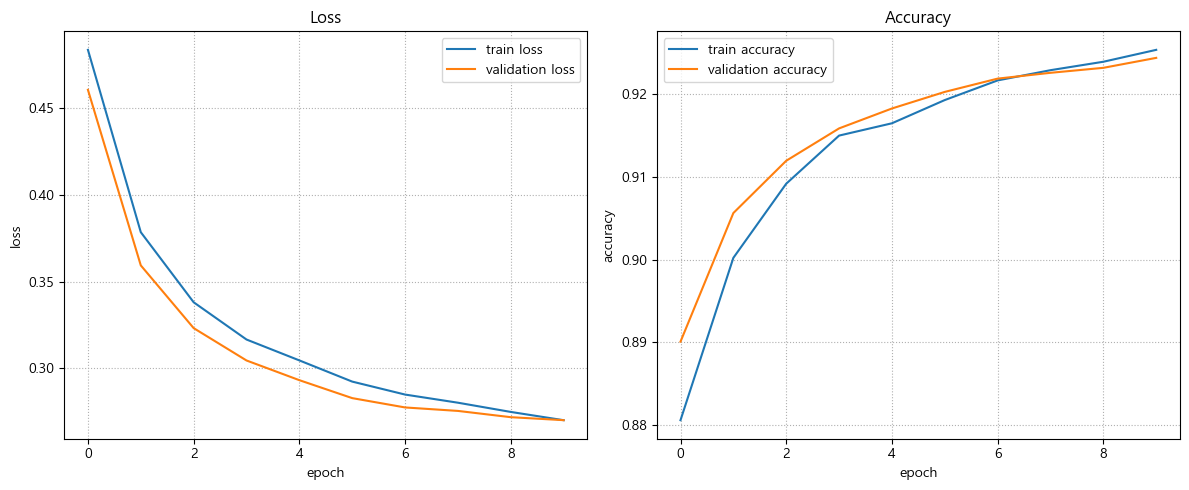

In [48]:
plot_fit_result(train_loss_list, train_acc_list, valid_loss_list, valid_acc_list)

In [49]:
#  Layer함수들을 묶어서 Layer block으로 만들 때 사용. (순차적으로 실행되는 모델을 간단하게 구현할 때도 사용.)
a = nn.Sequential(
    nn.Linear(1,2), nn.ReLU(), nn.Linear(2, 1)
)
x = torch.ones(1, 1, dtype=torch.float32)
y_hat = a(x)
y_hat

o = self.lr1(x)
o = self.relu(o)
o = self.lr2(o)

tensor([[-0.1413]], grad_fn=<AddmmBackward0>)

In [50]:
## 큰 모델
class BigModel(nn.Module):

    def __init__(self):
        super().__init__()
        # Linear -> ReLU  하나의 block 묶어서 정의.
        self.b1 = nn.Sequential(nn.Linear(784, 2048), nn.ReLU())
        self.b2 = nn.Sequential(nn.Linear(2048, 1024), nn.ReLU())
        self.b3 = nn.Sequential(nn.Linear(1024, 512), nn.ReLU())
        self.b4 = nn.Sequential(nn.Linear(512, 256), nn.ReLU())
        self.b5 = nn.Sequential(nn.Linear(256, 128), nn.ReLU())
        self.b6 = nn.Sequential(nn.Linear(128, 64), nn.ReLU())
        # output layer
        self.output = nn.Linear(64, 10)

    def forward(self, X):
        out = nn.Flatten()(X)
        out = self.b1(out)
        out = self.b2(out)
        out = self.b3(out)
        out = self.b4(out)
        out = self.b5(out)
        out = self.b6(out)
        out = self.output(out)
        return out        

In [51]:
big_model = BigModel()
summary(big_model, (batch_size, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
BigModel                                 [256, 10]                 --
├─Sequential: 1-1                        [256, 2048]               --
│    └─Linear: 2-1                       [256, 2048]               1,607,680
│    └─ReLU: 2-2                         [256, 2048]               --
├─Sequential: 1-2                        [256, 1024]               --
│    └─Linear: 2-3                       [256, 1024]               2,098,176
│    └─ReLU: 2-4                         [256, 1024]               --
├─Sequential: 1-3                        [256, 512]                --
│    └─Linear: 2-5                       [256, 512]                524,800
│    └─ReLU: 2-6                         [256, 512]                --
├─Sequential: 1-4                        [256, 256]                --
│    └─Linear: 2-7                       [256, 256]                131,328
│    └─ReLU: 2-8                         [256, 256]          

In [52]:
### 학습
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(big_model.parameters(), lr=lr)

train_loss_list, train_acc_list, valid_loss_list, valid_acc_list = fit(
    train_loader, test_loader, big_model, loss_fn, optimizer, 
    epochs,
    save_best_model=True, save_model_path='saved_models/big_model.pth', 
    device=device, mode="multi"
)

Epoch[1/100] - Train loss: 0.13331 Train Accucracy: 0.96117 || Validation Loss: 0.14105 Validation Accuracy: 0.95760
<<<<<<<저장: 1 - 이전 : inf, 현재: 0.14104789966950193
Epoch[2/100] - Train loss: 0.07544 Train Accucracy: 0.97765 || Validation Loss: 0.09499 Validation Accuracy: 0.97030
<<<<<<<저장: 2 - 이전 : 0.14104789966950193, 현재: 0.09498526807001326
Epoch[3/100] - Train loss: 0.04690 Train Accucracy: 0.98672 || Validation Loss: 0.07939 Validation Accuracy: 0.97770
<<<<<<<저장: 3 - 이전 : 0.09498526807001326, 현재: 0.07938830996863544
Epoch[4/100] - Train loss: 0.03682 Train Accucracy: 0.98885 || Validation Loss: 0.07394 Validation Accuracy: 0.97680
<<<<<<<저장: 4 - 이전 : 0.07938830996863544, 현재: 0.07394300557498354
Epoch[5/100] - Train loss: 0.02997 Train Accucracy: 0.99122 || Validation Loss: 0.07785 Validation Accuracy: 0.97690
Epoch[6/100] - Train loss: 0.02319 Train Accucracy: 0.99312 || Validation Loss: 0.07583 Validation Accuracy: 0.97870
Epoch[7/100] - Train loss: 0.02284 Train Accucracy: 0.

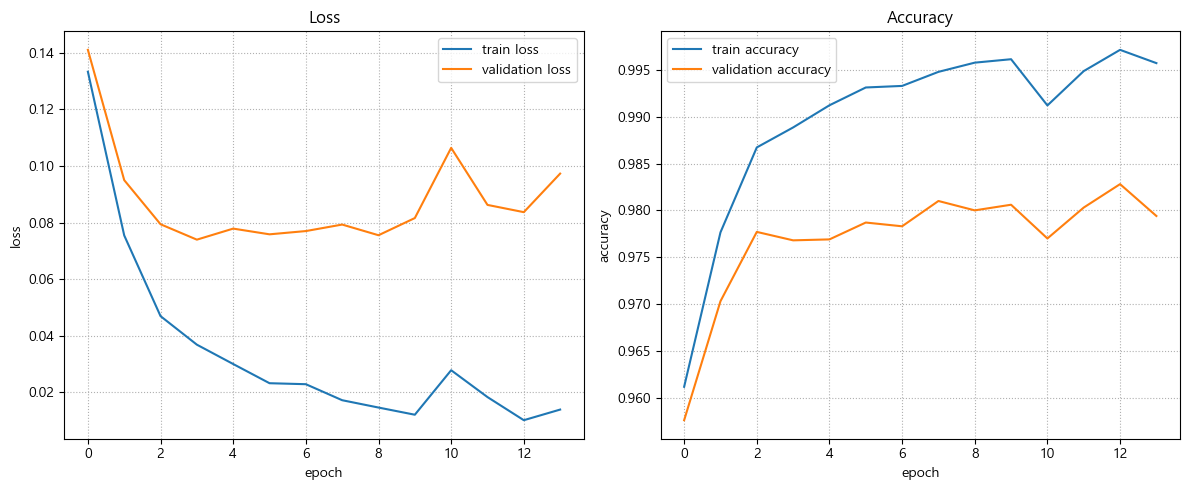

In [53]:
plot_fit_result(train_loss_list, train_acc_list, valid_loss_list, valid_acc_list)

# Dropout 예제
- dropout 각 레이어에 적용
    - dropout은 nn.Dropout 객체를 사용
    - 객체 생성시 dropout_rate 설정: 0.2 ~ 0.5
    - Drop시킬 노드를 가진 Layer 뒤에 추가한다.

In [55]:
class DropoutModel(nn.Module):
    """
    BigModel의 Layer들에 Dropout 추가.
    linear block:  Linear -> ReLU -> Dropout
    Dropout Layer는 model.train() 일때 작동. model.eval() 일때는 작동하지 않는다.
    """
    def __init__(self, dropout_rate=0.5):
        super().__init__()
        # Linear -> ReLU  하나의 block 묶어서 정의.
        self.b1 = nn.Sequential(nn.Linear(784, 2048), nn.ReLU(), nn.Dropout(p=dropout_rate))
        self.b2 = nn.Sequential(nn.Linear(2048, 1024), nn.ReLU(), nn.Dropout(p=dropout_rate))
        self.b3 = nn.Sequential(nn.Linear(1024, 512), nn.ReLU(), nn.Dropout(p=dropout_rate))
        self.b4 = nn.Sequential(nn.Linear(512, 256), nn.ReLU(), nn.Dropout(p=dropout_rate))
        self.b5 = nn.Sequential(nn.Linear(256, 128), nn.ReLU(), nn.Dropout(p=dropout_rate))
        self.b6 = nn.Sequential(nn.Linear(128, 64), nn.ReLU(), nn.Dropout(p=dropout_rate))
        # output layer
        self.output = nn.Sequential(nn.Linear(64, 10), nn.Dropout(p=dropout_rate))

    def forward(self, X):
        out = nn.Flatten()(X)
        out = self.b1(out)
        out = self.b2(out)
        out = self.b3(out)
        out = self.b4(out)
        out = self.b5(out)
        out = self.b6(out)
        out = self.output(out)
        return out        

In [56]:
# 모델 생성
do_model = DropoutModel()
# loss
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(do_model.parameters(), lr=lr)

In [58]:
summary(do_model, (batch_size, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
DropoutModel                             [256, 10]                 --
├─Sequential: 1-1                        [256, 2048]               --
│    └─Linear: 2-1                       [256, 2048]               1,607,680
│    └─ReLU: 2-2                         [256, 2048]               --
│    └─Dropout: 2-3                      [256, 2048]               --
├─Sequential: 1-2                        [256, 1024]               --
│    └─Linear: 2-4                       [256, 1024]               2,098,176
│    └─ReLU: 2-5                         [256, 1024]               --
│    └─Dropout: 2-6                      [256, 1024]               --
├─Sequential: 1-3                        [256, 512]                --
│    └─Linear: 2-7                       [256, 512]                524,800
│    └─ReLU: 2-8                         [256, 512]                --
│    └─Dropout: 2-9                      [256, 512]               

In [59]:
train_loss_list, train_acc_list, valid_loss_list, valid_acc_list = fit(
    train_loader, test_loader, do_model, loss_fn, optimizer, 
    epochs,
    save_best_model=True, save_model_path='saved_models/do_model.pth', 
    device=device, mode="multi"
)

Epoch[1/100] - Train loss: 0.45508 Train Accucracy: 0.87123 || Validation Loss: 0.45464 Validation Accuracy: 0.86580
<<<<<<<저장: 1 - 이전 : inf, 현재: 0.45463640950620177
Epoch[2/100] - Train loss: 0.17931 Train Accucracy: 0.95627 || Validation Loss: 0.18430 Validation Accuracy: 0.95600
<<<<<<<저장: 2 - 이전 : 0.45463640950620177, 현재: 0.184296519565396
Epoch[3/100] - Train loss: 0.15775 Train Accucracy: 0.96590 || Validation Loss: 0.16266 Validation Accuracy: 0.96170
<<<<<<<저장: 3 - 이전 : 0.184296519565396, 현재: 0.16266275937668978
Epoch[4/100] - Train loss: 0.14186 Train Accucracy: 0.96842 || Validation Loss: 0.15345 Validation Accuracy: 0.96500
<<<<<<<저장: 4 - 이전 : 0.16266275937668978, 현재: 0.15345095666125416
Epoch[5/100] - Train loss: 0.11539 Train Accucracy: 0.97330 || Validation Loss: 0.13553 Validation Accuracy: 0.96870
<<<<<<<저장: 5 - 이전 : 0.15345095666125416, 현재: 0.1355253687943332
Epoch[6/100] - Train loss: 0.10597 Train Accucracy: 0.97532 || Validation Loss: 0.12531 Validation Accuracy: 0.

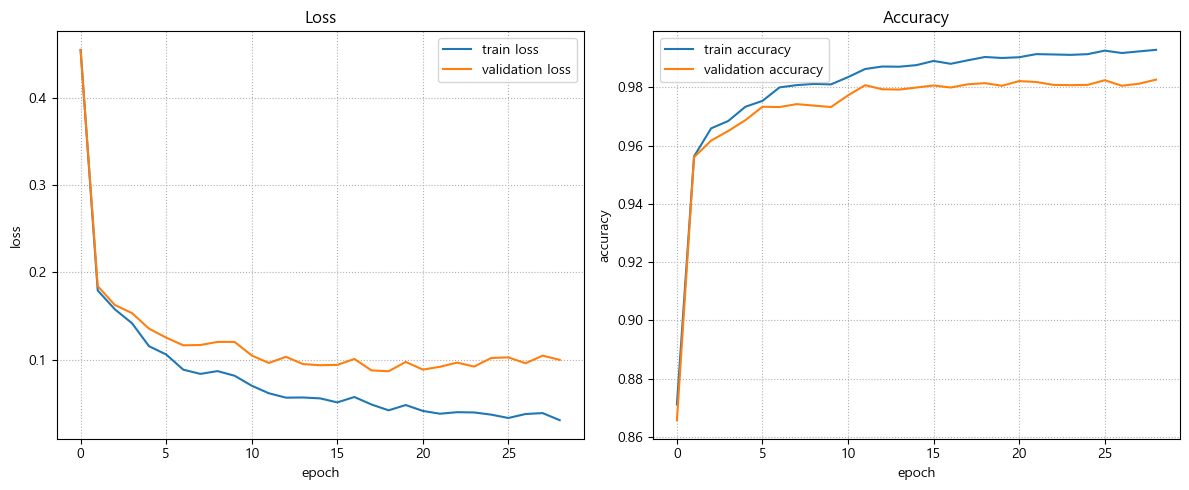

In [62]:
plot_fit_result(train_loss_list, train_acc_list, valid_loss_list, valid_acc_list)

# Batch Normalization
- Dense => BN => Activation => Dropout

In [66]:
class BatchNormModel(nn.Module):
    """
    DropoutModel의 Layer들에 Batch Normalization Layer 추가.
    linear block:  Linear ->  BatchNorm -> ReLU -> Dropout
    BatchNorm Layer는 model.train() 때 계산된 평균, 표준편차를 이용해서 model.eval() 일때는 scaling을 한다.
    """
    def __init__(self, dropout_rate=0.5):
        super().__init__()
        # Linear -> ReLU  하나의 block 묶어서 정의.
        self.b1 = nn.Sequential(nn.Linear(784, 2048), 
                                      nn.BatchNorm1d(2048), ## 입력 Feature 수(출력 features)
                                      nn.ReLU(), 
                                      nn.Dropout(p=dropout_rate))
        self.b2 = nn.Sequential(
            nn.Linear(2048, 1024), 
            nn.BatchNorm1d(1024), 
            nn.ReLU(), 
            nn.Dropout(p=dropout_rate))
        
        self.b3 = nn.Sequential(
            nn.Linear(1024, 512), 
            nn.BatchNorm1d(512), 
            nn.ReLU(), 
            nn.Dropout(p=dropout_rate))
        
        self.b4 = nn.Sequential(
            nn.Linear(512, 256), 
            nn.BatchNorm1d(256), 
            nn.ReLU(), 
            nn.Dropout(p=dropout_rate))
        
        self.b5 = nn.Sequential(
            nn.Linear(256, 128),
            nn.BatchNorm1d(128), 
            nn.ReLU(),
            nn.Dropout(p=dropout_rate))
        
        self.b6 = nn.Sequential(
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(), 
            nn.Dropout(p=dropout_rate))
        # output layer
        # 마지막 Layer에는 BatchNorm을 정의할 필요 없다. (이 출력을 다음 입력으로 사용안하므로.)
        self.output = nn.Sequential(   
            nn.Linear(64, 10), 
            nn.Dropout(p=dropout_rate))

    def forward(self, X):
        out = nn.Flatten()(X)
        out = self.b1(out)
        out = self.b2(out)
        out = self.b3(out)
        out = self.b4(out)
        out = self.b5(out)
        out = self.b6(out)
        out = self.output(out)
        return out        

In [67]:
bn_model = BatchNormModel()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(bn_model.parameters(), lr=lr)

In [68]:
summary(bn_model, (batch_size, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
BatchNormModel                           [256, 10]                 --
├─Sequential: 1-1                        [256, 2048]               --
│    └─Linear: 2-1                       [256, 2048]               1,607,680
│    └─BatchNorm1d: 2-2                  [256, 2048]               4,096
│    └─ReLU: 2-3                         [256, 2048]               --
│    └─Dropout: 2-4                      [256, 2048]               --
├─Sequential: 1-2                        [256, 1024]               --
│    └─Linear: 2-5                       [256, 1024]               2,098,176
│    └─BatchNorm1d: 2-6                  [256, 1024]               2,048
│    └─ReLU: 2-7                         [256, 1024]               --
│    └─Dropout: 2-8                      [256, 1024]               --
├─Sequential: 1-3                        [256, 512]                --
│    └─Linear: 2-9                       [256, 512]              

In [69]:
train_loss_list, train_acc_list, valid_loss_list, valid_acc_list = fit(
    train_loader, test_loader, bn_model, loss_fn, optimizer, 
    10,  # epochs
    save_best_model=True, save_model_path='saved_models/bn_model.pth', 
    device=device, mode="multi"
)

Epoch[1/10] - Train loss: 0.31237 Train Accucracy: 0.94685 || Validation Loss: 0.31357 Validation Accuracy: 0.94460
<<<<<<<저장: 1 - 이전 : inf, 현재: 0.31357164289802314
Epoch[2/10] - Train loss: 0.17021 Train Accucracy: 0.96193 || Validation Loss: 0.17409 Validation Accuracy: 0.95700
<<<<<<<저장: 2 - 이전 : 0.31357164289802314, 현재: 0.17409214875660836
Epoch[3/10] - Train loss: 0.13673 Train Accucracy: 0.96798 || Validation Loss: 0.14246 Validation Accuracy: 0.96500
<<<<<<<저장: 3 - 이전 : 0.17409214875660836, 현재: 0.1424573881784454
Epoch[4/10] - Train loss: 0.10697 Train Accucracy: 0.97462 || Validation Loss: 0.12042 Validation Accuracy: 0.96910
<<<<<<<저장: 4 - 이전 : 0.1424573881784454, 현재: 0.1204208014300093
Epoch[5/10] - Train loss: 0.09979 Train Accucracy: 0.97697 || Validation Loss: 0.11277 Validation Accuracy: 0.97140
<<<<<<<저장: 5 - 이전 : 0.1204208014300093, 현재: 0.11277180509641767
Epoch[6/10] - Train loss: 0.08964 Train Accucracy: 0.97913 || Validation Loss: 0.11393 Validation Accuracy: 0.96990

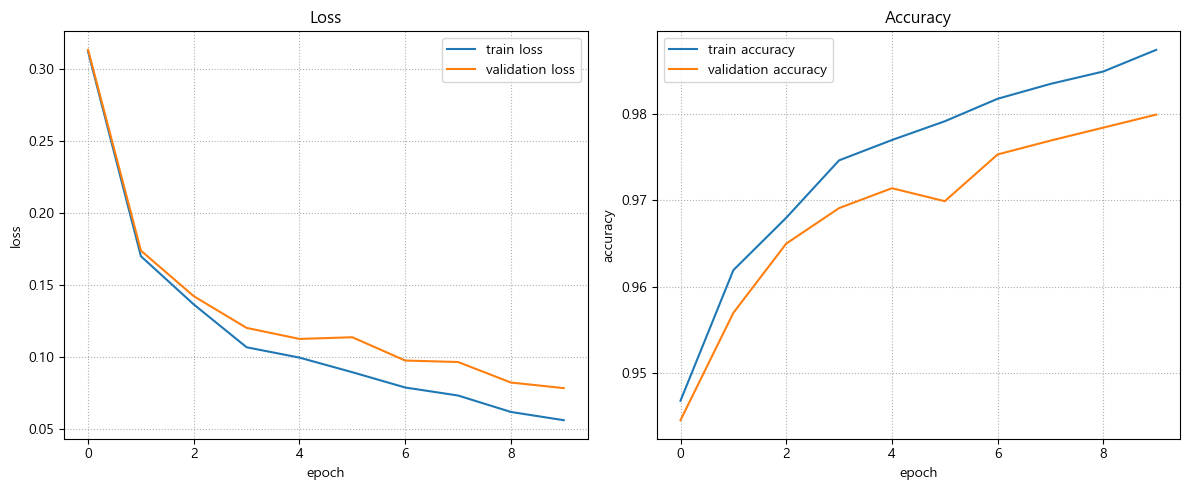

In [70]:
plot_fit_result(train_loss_list, train_acc_list, valid_loss_list, valid_acc_list)

# Learning rate decay

### Optimizer와 Learning rate scheduler의 속성, 메소드 확인
- 파이토치는 `torch.optim` 모듈에서 다양한 Learning rate 알고리즘을 제공한다.

In [85]:
torch.optim.Adam?

Init signature:
torch.optim.Adam(
    params: Union[Iterable[torch.Tensor], Iterable[Dict[str, Any]]],
    lr: Union[float, torch.Tensor] = 0.001,
    betas: Tuple[float, float] = (0.9, 0.999),
    eps: float = 1e-08,
    weight_decay: float = 0,
    amsgrad: bool = False,
    *,
    foreach: Optional[bool] = None,
    maximize: bool = False,
    capturable: bool = False,
    differentiable: bool = False,
    fused: Optional[bool] = None,
)
Docstring:     
Implements Adam algorithm.

.. math::
   \begin{aligned}
        &\rule{110mm}{0.4pt}                                                                 \\
        &\textbf{input}      : \gamma \text{ (lr)}, \beta_1, \beta_2
            \text{ (betas)},\theta_0 \text{ (params)},f(\theta) \text{ (objective)}          \\
        &\hspace{13mm}      \lambda \text{ (weight decay)},  \: \textit{amsgrad},
            \:\textit{maximize}                                                              \\
        &\textbf{initialize} :  m_0 \leftar

In [82]:
### optimizer 정의
optimizer = torch.optim.Adam(bn_model.parameters(), lr=0.001)  # (파라미터, lr)

In [83]:
### Optimizer 속성들을 묶어서 조회.
optim_infos = optimizer.param_groups
print(type(optim_infos), len(optim_infos))
optim_info = optim_infos[0]
print(type(optim_info))
print(optim_info.keys())

<class 'list'> 1
<class 'dict'>
dict_keys(['params', 'lr', 'betas', 'eps', 'weight_decay', 'amsgrad', 'maximize', 'foreach', 'capturable', 'differentiable', 'fused'])


In [87]:
optim_info['lr'], optim_info['betas'], optim_info['params']

(0.001,
 (0.9, 0.999),
 [Parameter containing:
  tensor([[-0.0139,  0.0164, -0.0200,  ..., -0.0299, -0.0097, -0.0069],
          [ 0.0286,  0.0082,  0.0252,  ..., -0.0255,  0.0192,  0.0057],
          [-0.0171,  0.0041,  0.0049,  ..., -0.0177,  0.0071,  0.0186],
          ...,
          [-0.0268, -0.0331, -0.0087,  ...,  0.0012,  0.0313, -0.0127],
          [ 0.0099, -0.0156,  0.0133,  ...,  0.0114,  0.0349, -0.0200],
          [-0.0107,  0.0013,  0.0357,  ...,  0.0324,  0.0318,  0.0132]],
         requires_grad=True),
  Parameter containing:
  tensor([ 0.0304,  0.0175,  0.0070,  ...,  0.0296, -0.0253,  0.0015],
         requires_grad=True),
  Parameter containing:
  tensor([1.0223, 0.9170, 0.9701,  ..., 0.9360, 1.0249, 1.0331],
         requires_grad=True),
  Parameter containing:
  tensor([-0.1641, -0.1482, -0.1379,  ..., -0.0692, -0.0502, -0.0868],
         requires_grad=True),
  Parameter containing:
  tensor([[ 0.0042, -0.0189, -0.0231,  ..., -0.0242, -0.0115,  0.0346],
          

In [102]:
####### LearningRate Scheduler에 의해 변화되는 learning rate의 흐름을 시각화.
def plot_lr(title, lr_list):
    plt.figure(figsize=(15, 7))
    plt.plot(range(len(lr_list)),  lr_list)
    
    plt.title(title)
    xticks = [x for x in range(len(lr_list)) if x % 10 == 0] # 눈금 표시 -> 5 배수 자리에만 눈금.
    plt.xticks(xticks, rotation=45)
    plt.xlabel("Epochs or Steps")
    plt.ylabel("LR")
    plt.grid(True, linestyle=":")
    plt.show()

In [91]:
# import numpy as np
# plot_lr("제목", np.arange(1, 0.001, -0.01))

#### StepLR

In [93]:
### StepLR - 계단 형태로 LR를 변화시킨다.  특정 epoch(step) 마다 특정 비율로 LR를 변경.
# 모델, loss_fn, optimizer
optimizer = torch.optim.Adam(bn_model.parameters(), lr=0.001)
# LearningRate Scheduler를 생성.
step_lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer, # 스케줄링할 Learning Rate를 가지고 있는 Optimizer
    step_size=30, # 몇 step/epoch 마다 LR을 변경할 것인지 지정. (lr_scheduler.step() 한번 호출 -> 1step)
    gamma=0.5,  # 변경 비율. new_lr = 현재_lr * gamma
)

print("현재 Learning 확인:", optimizer.param_groups[0]['lr'], step_lr_scheduler.get_last_lr())

현재 Learning 확인: 0.001 [0.001]


In [95]:
epochs = 300
step_size = 10  # 1 에폭당 파라미터업데이트(step) 횟수
lr_list = [] # 에폭별 learning rate 들을 저장할 리스트.

for epoch in range(epochs):
    # 1 epoch 학습
    for _ in range(step_size):   # for x, y in train_loader: 대체코드
        # 1 step 학습: 모델 추론 -> loss 계산 -> gradient 계산.
        optimizer.step()  # 1스텝: 파라미터 업데이트
        optimizer.zero_grad()
        # step_lr_scheduler.step()  # step_size(30) 단위: step
    lr_list.append(step_lr_scheduler.get_last_lr()[0]) # 현재 epoch의 lr를 저장.==> 확인을 위한 코드.
    step_lr_scheduler.step()  # step_size(30) 단위: epoch ==> 30 epoch당 한번씩 lr를 변경.

In [98]:
for i, lr in enumerate(lr_list, start=1):
    print(i, lr, sep="-")

1-0.001
2-0.001
3-0.001
4-0.001
5-0.001
6-0.001
7-0.001
8-0.001
9-0.001
10-0.001
11-0.001
12-0.001
13-0.001
14-0.001
15-0.001
16-0.001
17-0.001
18-0.001
19-0.001
20-0.001
21-0.001
22-0.001
23-0.001
24-0.001
25-0.001
26-0.001
27-0.001
28-0.001
29-0.001
30-0.001
31-0.0005
32-0.0005
33-0.0005
34-0.0005
35-0.0005
36-0.0005
37-0.0005
38-0.0005
39-0.0005
40-0.0005
41-0.0005
42-0.0005
43-0.0005
44-0.0005
45-0.0005
46-0.0005
47-0.0005
48-0.0005
49-0.0005
50-0.0005
51-0.0005
52-0.0005
53-0.0005
54-0.0005
55-0.0005
56-0.0005
57-0.0005
58-0.0005
59-0.0005
60-0.0005
61-0.00025
62-0.00025
63-0.00025
64-0.00025
65-0.00025
66-0.00025
67-0.00025
68-0.00025
69-0.00025
70-0.00025
71-0.00025
72-0.00025
73-0.00025
74-0.00025
75-0.00025
76-0.00025
77-0.00025
78-0.00025
79-0.00025
80-0.00025
81-0.00025
82-0.00025
83-0.00025
84-0.00025
85-0.00025
86-0.00025
87-0.00025
88-0.00025
89-0.00025
90-0.00025
91-0.000125
92-0.000125
93-0.000125
94-0.000125
95-0.000125
96-0.000125
97-0.000125
98-0.000125
99-0.000125
1

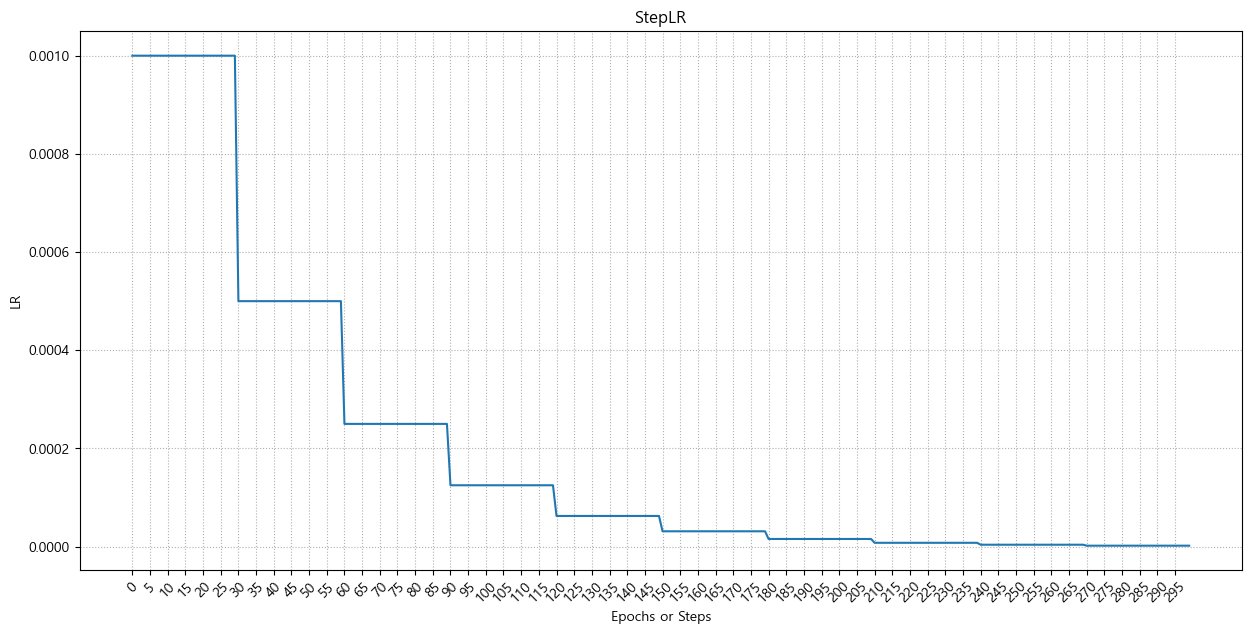

In [101]:
plot_lr("StepLR", lr_list)

#### CosineAnnealingLR
cosine 그래프를 그리면서 learning rate를 변경 하는 방식.  
최근에는 learning rate를 단순히 감소시키기 보다는 감소와 증가를 반복하여 진동하는 방식으로 최적점을 찾아가는 알고리즘을 많이 사용한다. 이러한 방법 중 가장 간단하면서도 많이 사용되는 방법이 CosineAnnealingLR이다.

In [103]:
optimizer = torch.optim.Adam(bn_model.parameters(), lr=0.001)
ca_lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer, 
    T_max=10, # 주기 step수 를 지정.  "최대_lr -> 최소_lr" 와 "최소_lr -> 최대_lr": 주기 step수(epoch, step) 지정.)
    eta_min = 0.00001 # 최소 lr,  최대 lr: 초기 lr값(0.001)   0.001 ~ 0.00001
)

In [104]:
lr_list2 = []
for epoch in range(epoch):
    for _ in range(step_size):
        # .... 학습
        optimizer.step()
        optimizer.zero_grad()
    lr_list2.append(ca_lr_scheduler.get_last_lr()[0])
    ### lr 업데이트
    ca_lr_scheduler.step()

In [105]:
lr_list2

[0.001,
 0.0009757729755661011,
 0.000905463412215599,
 0.0007959536998847742,
 0.000657963412215599,
 0.000505,
 0.0003520365877844011,
 0.00021404630011522585,
 0.00010453658778440107,
 3.4227024433899005e-05,
 1e-05,
 3.4227024433899005e-05,
 0.00010453658778440146,
 0.00021404630011522671,
 0.00035203658778440265,
 0.0005050000000000023,
 0.000657963412215602,
 0.0007959536998847778,
 0.0009054634122156032,
 0.0009757729755661056,
 0.0010000000000000046,
 0.0009757729755661055,
 0.0009054634122156035,
 0.0007959536998847779,
 0.0006579634122156021,
 0.0005050000000000024,
 0.0003520365877844028,
 0.00021404630011522688,
 0.00010453658778440157,
 3.4227024433899175e-05,
 1e-05,
 3.4227024433899005e-05,
 0.00010453658778440114,
 0.00021404630011522612,
 0.0003520365877844016,
 0.000505000000000001,
 0.0006579634122156004,
 0.0007959536998847761,
 0.0009054634122156011,
 0.0009757729755661035,
 0.0010000000000000026,
 0.000975772975566104,
 0.0009054634122156017,
 0.000795953699884776

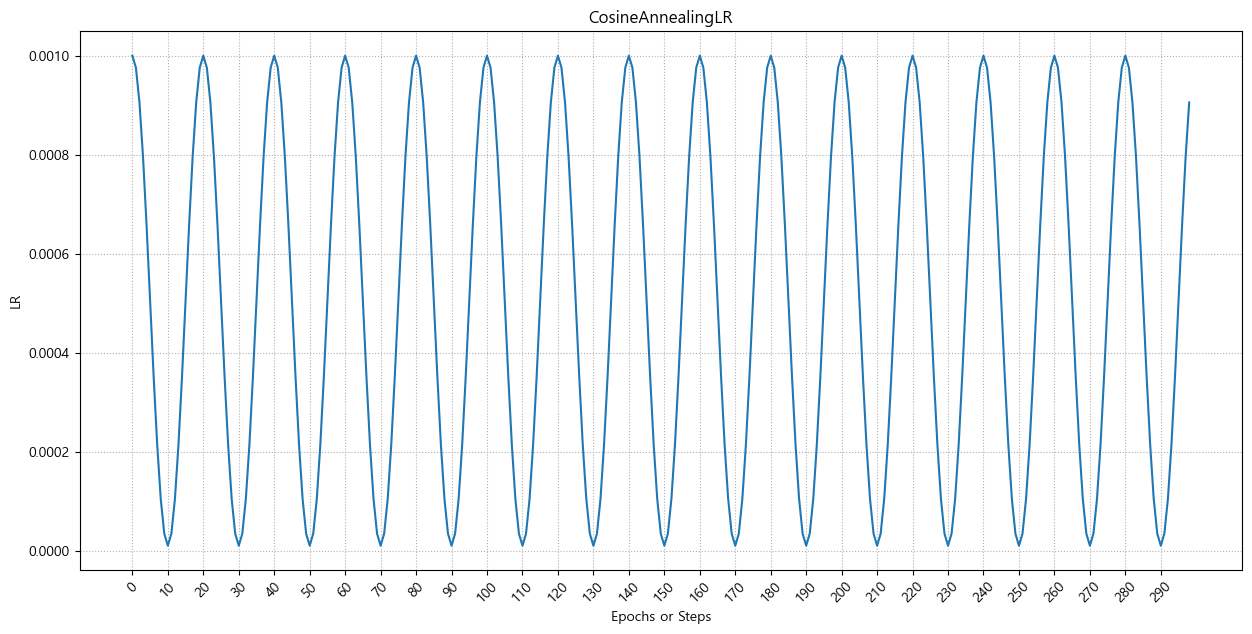

In [106]:
plot_lr("CosineAnnealingLR", lr_list2)

#### CosineAnnealingWarmRestarts

cosine annealing의 스케쥴링에 cosine 주기의 에폭을 점점 늘리거나 줄일 수 있다. (보통 늘린다.)

In [108]:
#### 변화 주기의 비율을 변경하는 것을 WarmStart
optimizer = torch.optim.Adam(bn_model.parameters(), lr=0.001)
caws_lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, 
    T_0=10, # CosineAnnealingLR의 T_max값의 역할. -> 시작 주기.
    T_mult=2, # 주기를 어떤 비율로 변경할지. 새로운주기 = 현재_주기 * T_mult
    eta_min=1e-5 # 0.00001  # 최소 lr.     초기 LR <-> 최소 LR
)

In [109]:
lr_list3 = []
for epoch in range(epochs):
    for _ in range(step_size):
        # 학습 .... 
        optimizer.step()
        optimizer.zero_grad()
    lr_list3.append(caws_lr_scheduler.get_last_lr()[0])
    caws_lr_scheduler.step()

In [110]:
lr_list3

[0.001,
 0.0009757729755661011,
 0.000905463412215599,
 0.0007959536998847742,
 0.000657963412215599,
 0.000505,
 0.0003520365877844011,
 0.00021404630011522585,
 0.00010453658778440107,
 3.4227024433899005e-05,
 0.001,
 0.0009939057285945933,
 0.0009757729755661011,
 0.0009460482294732421,
 0.000905463412215599,
 0.000855017856687341,
 0.0007959536998847742,
 0.0007297252973710757,
 0.000657963412215599,
 0.0005824350601949143,
 0.000505,
 0.0004275649398050859,
 0.0003520365877844011,
 0.0002802747026289244,
 0.00021404630011522585,
 0.000154982143312659,
 0.00010453658778440107,
 6.395177052675794e-05,
 3.4227024433899005e-05,
 1.609427140540686e-05,
 0.001,
 0.0009984740801978985,
 0.0009939057285945933,
 0.00098632311059685,
 0.0009757729755661011,
 0.000962320368593087,
 0.0009460482294732421,
 0.0009270568813552756,
 0.000905463412215599,
 0.0008814009529720154,
 0.000855017856687341,
 0.0008264767839234411,
 0.0007959536998847742,
 0.0007636367895343947,
 0.0007297252973710757,

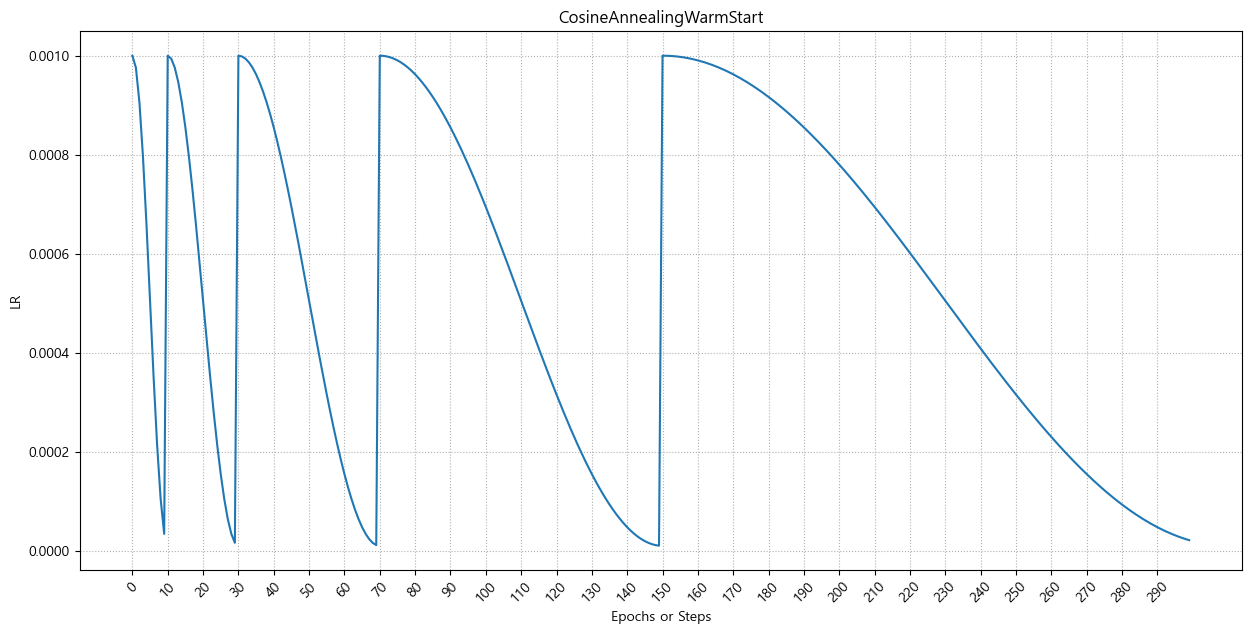

In [111]:
plot_lr("CosineAnnealingWarmStart", lr_list3)